In [1]:
import numpy as np
import astropy
from astropy.table import Table, Column,join,vstack
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output
import pickle
import os
from glob import glob
from shutil import copyfile
from pymoc import MOC
from pymoc.util import catalog
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.neighbors import KernelDensity

In [2]:
from mltier import (get_center, get_n_m, estimate_q_m, Field, SingleMLEstimator, MultiMLEstimator,
                     parallel_process, get_sigma_all, get_q_m, get_threshold, q0_min_level, q0_min_numbers,
                     get_n_m_kde, estimate_q_m_kde, get_q_m_kde, describe)
from Q0_calc import Q0_calc

#### Read in the optical and infrared data and the radio data

In [3]:
opt_ir_cat = Table.read('data/Lockman-SWIRE_20180219.fits')

In [4]:
lofar_all = Table.read('data/deep-lockman-v0.1.cat.fits')

In [5]:
opt_colname = 'm_megacam_r'
ir_colname = 'm_irac_i1'

#### Define the field 

In [6]:
#select the moc of the optical data
MOC_loc = 'mocs/DF-SERVS_Lockman-SWIRE_MOC.fits'
MHz150_MOC = MOC(filename=MOC_loc)

In [7]:
ra_down, ra_up, dec_down, dec_up = min(lofar_all['RA']),max(lofar_all['RA']),min(lofar_all['DEC']),max(lofar_all['DEC'])
field = Field(ra_down, ra_up, dec_down, dec_up, MHz150_MOC)

field area is defined by a MOC


#### Filter the catalogues

In [8]:
# remove sources with a major axis greater than 30 arcseconds
lofar_aux = lofar_all[~np.isnan(lofar_all['Maj'])]
lofar = field.filter_catalogue(lofar_aux[(lofar_aux['Maj'] < 30.)], 
                               colnames=("RA", "DEC"))

filtering in a MOC


In [9]:
opt_ir = field.filter_catalogue(opt_ir_cat, 
                               colnames=("ra", "dec"))
#remove sources with no detection in the opt or ir bands used for xmatching
mask = (~np.isnan(opt_ir[opt_colname])) | (~np.isnan(opt_ir[ir_colname]))
opt_ir = opt_ir[mask]

filtering in a MOC


In [10]:
opt_ir["colour"] = opt_ir[opt_colname] - opt_ir[ir_colname]

In [11]:
opt_ir_index = np.arange(len(opt_ir))

In [12]:
opt_ir_coords = SkyCoord(opt_ir['ra'], 
                           opt_ir['dec'], 
                           unit=(u.deg, u.deg), 
                           frame='icrs')

In [13]:
lofar_coords = SkyCoord(lofar['RA'], 
                       lofar['DEC'], 
                       unit=(u.deg, u.deg), 
                       frame='icrs')

In [14]:
opt_ir_num_both = (~np.isnan(opt_ir[opt_colname]) & ~np.isnan(opt_ir[ir_colname])) # number of sources detected in opt and ir
opt_ir_num_opt = (~np.isnan(opt_ir[opt_colname]) & np.isnan(opt_ir[ir_colname])) # number of sources detected in opt only
opt_ir_num_ir =(np.isnan(opt_ir[opt_colname]) & ~np.isnan(opt_ir[ir_colname])) # number of sources detected in ir only
opt_num = opt_ir_num_both | opt_ir_num_opt
ir_num = opt_ir_num_both | opt_ir_num_ir

opt_cat = opt_ir[opt_num]
ir_cat = opt_ir[ir_num]

In [15]:
print("Total    - ", len(opt_ir))
print("opt and ir - ", np.sum(opt_ir_num_both))
print("Only opt   - ", np.sum(opt_ir_num_opt))
print("With opt   - ", np.sum(opt_num))
print("Only ir  - ", np.sum(opt_ir_num_ir))
print("With ir  - ", np.sum(ir_num))

Total    -  1395953
i and W1 -  496542
Only i   -  662040
With i   -  1158582
Only W1  -  237371
With W1  -  733913


check the distribution of sources to make sure the selected area is correct and that there are no gaps that could influence the calculation of Q0

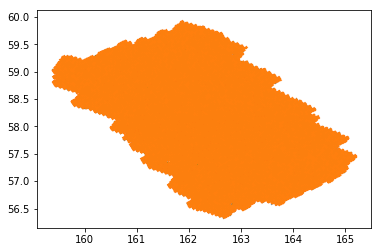

In [16]:
x = lofar['RA']
y = lofar['DEC']
plt.scatter(x,y,s=0.1)

x = opt_ir['ra']
y = opt_ir['dec']
plt.scatter(x,y,s=0.01)
plt.show()

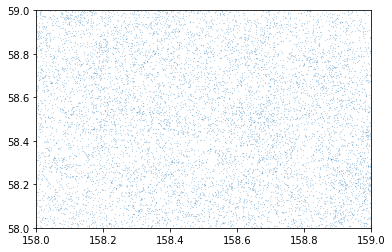

In [17]:
mask = ~np.isnan(opt_ir_cat['m_gpc1_i'])
x = opt_ir_cat['ra'][mask]
y = opt_ir_cat['dec'][mask]
plt.scatter(x,y,s=0.01)
plt.xlim(158,159)
plt.ylim(58,59)
plt.show()

### Compute Q0 for the optical and IR

In [18]:
Q0_opt,search_rad_r = Q0_calc(lofar,opt_cat,'RA','DEC','ra','dec',opt_colname,min(lofar['RA']),max(lofar['RA']),min(lofar['DEC']),max(lofar['DEC']),0.1,8,30,moc=MHz150_MOC)

field area is defined by a MOC
filtering in a MOC
filtering in a MOC
[    0     1     2 ... 11632 11633 11634]
7123
starting to find Q0. This will take a while
finding Q0 with radius = 0.1 arcseconds
number of random sources with no matches: 7119
number of real sources with no matches: 6925
number of random sources with no matches: 7121
number of real sources with no matches: 6925
number of random sources with no matches: 7119
number of real sources with no matches: 6925
number of random sources with no matches: 7120
number of real sources with no matches: 6925
number of random sources with no matches: 7121
number of real sources with no matches: 6925
number of random sources with no matches: 7120
number of real sources with no matches: 6925
number of random sources with no matches: 7120
number of real sources with no matches: 6925
number of random sources with no matches: 7118
number of real sources with no matches: 6925
number of random sources with no matches: 7118
number of real so

number of random sources with no matches: 5579
number of real sources with no matches: 1451
number of random sources with no matches: 5605
number of real sources with no matches: 1451
number of random sources with no matches: 5550
number of real sources with no matches: 1451
number of random sources with no matches: 5618
number of real sources with no matches: 1451
number of random sources with no matches: 5642
number of real sources with no matches: 1451
number of random sources with no matches: 5581
number of real sources with no matches: 1451
number of random sources with no matches: 5563
number of real sources with no matches: 1451
finding Q0 with radius = 2.5517241379310343 arcseconds
number of random sources with no matches: 5295
number of real sources with no matches: 1330
number of random sources with no matches: 5262
number of real sources with no matches: 1330
number of random sources with no matches: 5311
number of real sources with no matches: 1330
number of random sources 

number of random sources with no matches: 2963
number of real sources with no matches:  703
number of random sources with no matches: 2938
number of real sources with no matches:  703
finding Q0 with radius = 4.73103448275862 arcseconds
number of random sources with no matches: 2694
number of real sources with no matches:  635
number of random sources with no matches: 2727
number of real sources with no matches:  635
number of random sources with no matches: 2735
number of real sources with no matches:  635
number of random sources with no matches: 2695
number of real sources with no matches:  635
number of random sources with no matches: 2641
number of real sources with no matches:  635
number of random sources with no matches: 2626
number of real sources with no matches:  635
number of random sources with no matches: 2725
number of real sources with no matches:  635
number of random sources with no matches: 2736
number of real sources with no matches:  635
number of random sources wi

number of random sources with no matches:  979
number of real sources with no matches:  240
number of random sources with no matches: 1023
number of real sources with no matches:  240
number of random sources with no matches:  983
number of real sources with no matches:  240
number of random sources with no matches:  989
number of real sources with no matches:  240
number of random sources with no matches: 1004
number of real sources with no matches:  240
number of random sources with no matches:  997
number of real sources with no matches:  240
number of random sources with no matches: 1001
number of real sources with no matches:  240
number of random sources with no matches: 1029
number of real sources with no matches:  240
finding Q0 with radius = 7.182758620689654 arcseconds
number of random sources with no matches:  849
number of real sources with no matches:  213
number of random sources with no matches:  849
number of real sources with no matches:  213
number of random sources w

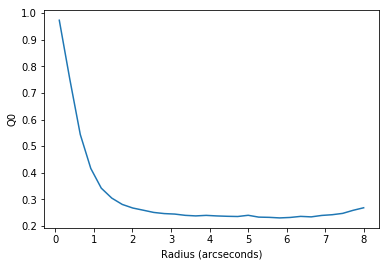

Q0 = 0.7693690064489477
search radius = 5.820689655172413


In [19]:
x = search_rad_r
y = 1 - np.array(Q0_opt)
plt.plot(x,y)
plt.xlabel('Radius (arcseconds)')
plt.ylabel('Q0')
plt.show()

Q0 = max(Q0_opt)
search_rad_opt = search_rad_r[Q0_opt == Q0][0]
#Q0 = popt[0]
#search_rad = 6.9103

print('Q0 = {}'.format(Q0))
print('search radius = {}'.format(search_rad_opt))
Q0_opt = Q0

In [20]:
Q0_ir,search_rad_r = Q0_calc(lofar,ir_cat,'RA','DEC','ra','dec',ir_colname,min(lofar['RA']),max(lofar['RA']),min(lofar['DEC']),max(lofar['DEC']),0.1,8,30,moc=MHz150_MOC)

field area is defined by a MOC
filtering in a MOC
filtering in a MOC
[    0     1     2 ... 11632 11633 11634]
7123
starting to find Q0. This will take a while
finding Q0 with radius = 0.1 arcseconds
number of random sources with no matches: 7121
number of real sources with no matches: 6878
number of random sources with no matches: 7123
number of real sources with no matches: 6878
number of random sources with no matches: 7120
number of real sources with no matches: 6878
number of random sources with no matches: 7120
number of real sources with no matches: 6878
number of random sources with no matches: 7121
number of real sources with no matches: 6878
number of random sources with no matches: 7122
number of real sources with no matches: 6878
number of random sources with no matches: 7120
number of real sources with no matches: 6878
number of random sources with no matches: 7120
number of real sources with no matches: 6878
number of random sources with no matches: 7122
number of real so

number of random sources with no matches: 6049
number of real sources with no matches:  429
number of random sources with no matches: 6060
number of real sources with no matches:  429
number of random sources with no matches: 6031
number of real sources with no matches:  429
number of random sources with no matches: 6063
number of real sources with no matches:  429
number of random sources with no matches: 5985
number of real sources with no matches:  429
number of random sources with no matches: 6054
number of real sources with no matches:  429
number of random sources with no matches: 6031
number of real sources with no matches:  429
finding Q0 with radius = 2.5517241379310343 arcseconds
number of random sources with no matches: 5807
number of real sources with no matches:  386
number of random sources with no matches: 5820
number of real sources with no matches:  386
number of random sources with no matches: 5767
number of real sources with no matches:  386
number of random sources 

number of random sources with no matches: 3760
number of real sources with no matches:  226
number of random sources with no matches: 3713
number of real sources with no matches:  226
finding Q0 with radius = 4.73103448275862 arcseconds
number of random sources with no matches: 3441
number of real sources with no matches:  217
number of random sources with no matches: 3472
number of real sources with no matches:  217
number of random sources with no matches: 3515
number of real sources with no matches:  217
number of random sources with no matches: 3376
number of real sources with no matches:  217
number of random sources with no matches: 3376
number of real sources with no matches:  217
number of random sources with no matches: 3459
number of real sources with no matches:  217
number of random sources with no matches: 3456
number of real sources with no matches:  217
number of random sources with no matches: 3476
number of real sources with no matches:  217
number of random sources wi

number of random sources with no matches: 1549
number of real sources with no matches:  154
number of random sources with no matches: 1526
number of real sources with no matches:  154
number of random sources with no matches: 1510
number of real sources with no matches:  154
number of random sources with no matches: 1506
number of real sources with no matches:  154
number of random sources with no matches: 1545
number of real sources with no matches:  154
number of random sources with no matches: 1512
number of real sources with no matches:  154
number of random sources with no matches: 1518
number of real sources with no matches:  154
number of random sources with no matches: 1500
number of real sources with no matches:  154
finding Q0 with radius = 7.182758620689654 arcseconds
number of random sources with no matches: 1403
number of real sources with no matches:  145
number of random sources with no matches: 1371
number of real sources with no matches:  145
number of random sources w

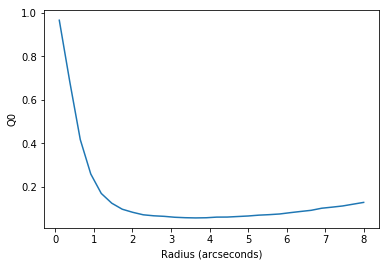

Q0 = 0.9433182264476934
search radius = 3.6413793103448273


In [21]:
x = search_rad_r
y = 1 - np.array(Q0_ir)
plt.plot(x,y)
plt.xlabel('Radius (arcseconds)')
plt.ylabel('Q0')
plt.show()
Q0 = max(Q0_ir)

search_rad_ir = search_rad_r[Q0_ir == Q0][0]
#Q0 = popt[0]
#search_rad = 6.9103

print('Q0 = {}'.format(Q0))
print('search radius = {}'.format(search_rad_ir))
Q0_ir = Q0

### Prepare the optical likelihood ratio

In [22]:
opt_cat = opt_ir[opt_num]

In [23]:
bin_list_opt = np.arange(16., 30., 0.5)
center_opt = get_center(bin_list_opt)

In [24]:
bandwidth_opt = 0.5

#find the magnitude distribution of all sources n(m)
n_m_opt = get_n_m(opt_cat[opt_colname], bin_list_opt, field.area)
#find the magnitude distribution of all sources using a kernal instead of bining 
n_m_opt_kde = get_n_m_kde(opt_cat[opt_colname], center_opt, field.area, bandwidth=bandwidth_opt)
n_m_opt_kde_cs = np.cumsum(n_m_opt_kde)

#estimate q(m) using the method of Fleuren et al 2012
q_m_opt = estimate_q_m(opt_cat[opt_colname], 
                      bin_list_opt, 
                      n_m_opt, 
                      lofar_coords, 
                      opt_ir_coords[opt_num], 
                      radius=5)

#estimate q(m) using the method of fleuren et al 2012 but instead of binning the magnitudes using a
#kernal to create a smoother q(m)
q_m_opt_kde = estimate_q_m_kde(opt_cat[opt_colname], 
                      center_opt, 
                      n_m_opt_kde, 
                      lofar_coords, 
                      opt_ir_coords[opt_num], 
                      radius=5, 
                      bandwidth=bandwidth_opt)
q_m_opt_kde_cs = np.cumsum(q_m_opt_kde)

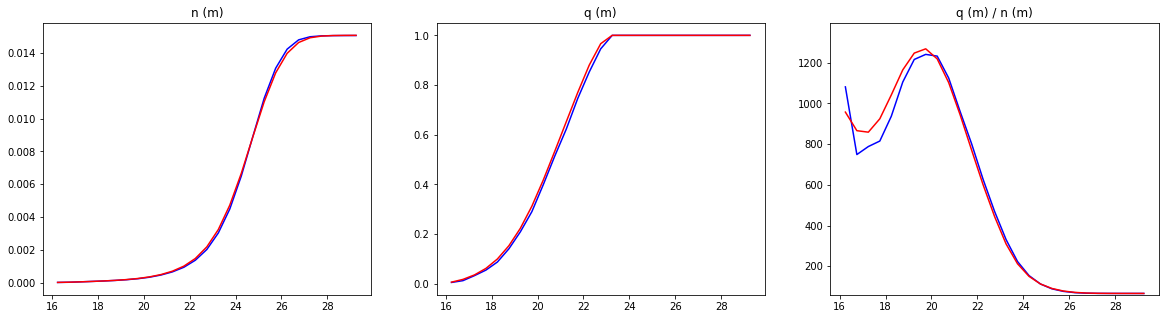

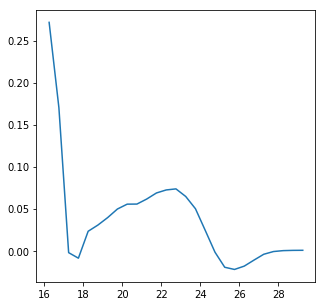

In [25]:
plt.rcParams["figure.figsize"] = (20,5)
plt.subplot(1,3,1)
plt.plot(center_opt, n_m_opt,color='blue');
plt.plot(center_opt, n_m_opt_kde_cs,color='red');
plt.title('n (m)')


plt.subplot(1,3,2)
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(center_opt, q_m_opt,color='blue');
plt.plot(center_opt, q_m_opt_kde_cs,color='red');
plt.title('q (m)')

plt.subplot(1,3,3)
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(center_opt, q_m_opt/n_m_opt,color='blue');
plt.plot(center_opt, q_m_opt_kde_cs/n_m_opt_kde_cs,color='red');
plt.ylim(0.9*np.min(q_m_opt_kde_cs/n_m_opt_kde_cs),1.1*np.max(q_m_opt_kde_cs/n_m_opt_kde_cs))
plt.title('q (m) / n (m)')
plt.show()

In [26]:
likelihood_ratio_opt = SingleMLEstimator(Q0_opt, n_m_opt_kde_cs, q_m_opt_kde_cs, center_opt)

### Prepare the IR likelihood ratio

In [27]:
ir_cat = opt_ir[ir_num]

In [28]:
bin_list_ir = np.arange(16., 28., 0.5)
center_ir = get_center(bin_list_ir)

In [29]:
bandwidth_ir = 0.5

n_m_ir = get_n_m(ir_cat[ir_colname], bin_list_ir, field.area)
n_m_ir_kde = get_n_m_kde(ir_cat[ir_colname], center_ir, field.area, bandwidth=bandwidth_ir)
n_m_ir_kde_cs = np.cumsum(n_m_ir_kde)

q_m_ir = estimate_q_m(ir_cat[ir_colname], 
                      bin_list_ir, 
                      n_m_ir, 
                      lofar_coords, 
                      opt_ir_coords[ir_num], 
                      radius=5)

q_m_ir_kde = estimate_q_m_kde(ir_cat[ir_colname], 
                      center_ir, 
                      n_m_ir_kde, 
                      lofar_coords, 
                      opt_ir_coords[ir_num], 
                      radius=5, 
                      bandwidth=bandwidth_ir)
q_m_ir_kde_cs = np.cumsum(q_m_ir_kde)

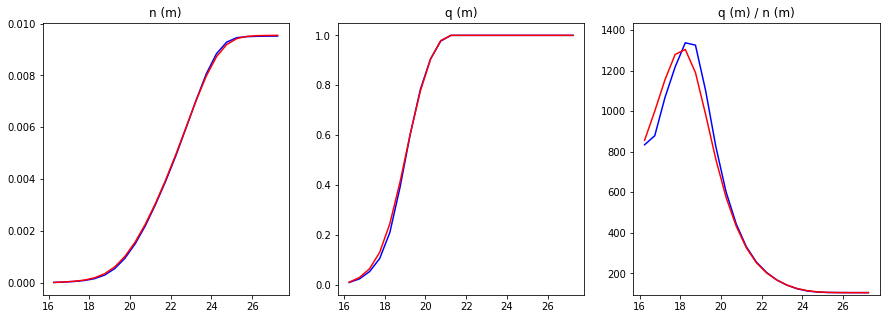

In [30]:
plt.rcParams["figure.figsize"] = (15,5)
plt.subplot(1,3,1)
plt.plot(center_ir, n_m_ir,color='blue');
plt.plot(center_ir, n_m_ir_kde_cs,color='red');
plt.title('n (m)')

plt.subplot(1,3,2)
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(center_ir, q_m_ir,color='blue');
plt.plot(center_ir, q_m_ir_kde_cs,color='red');
plt.title('q (m)')

plt.subplot(1,3,3)
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(center_ir, q_m_ir/n_m_ir,color='blue');
plt.plot(center_ir, q_m_ir_kde_cs/n_m_ir_kde_cs,color='red');
plt.ylim(0.9*np.min(q_m_ir_kde_cs/n_m_ir_kde_cs),1.1*np.max(q_m_ir_kde_cs/n_m_ir_kde_cs))
plt.title('q (m) / n (m)')
plt.show()

In [31]:
likelihood_ratio_ir = SingleMLEstimator(Q0_ir, n_m_ir_kde_cs, q_m_ir_kde_cs, center_ir)

### Start the magnitude only crossmatch

#### optical

In [32]:
import multiprocessing
n_cpus_total = multiprocessing.cpu_count()
n_cpus = max(1, n_cpus_total-1)

In [33]:
radius = 15
idx_lofar, idx_opt, d2d, d3d = search_around_sky(
    lofar_coords, opt_ir_coords[opt_num], radius*u.arcsec)

# create an array of the indexs of lofar sources with a possible crossmatch within the search radius
idx_lofar_unique = np.unique(idx_lofar)
print('number of LOFAR sources with a possible crossmatch within {} arcseconds is {}'.format(radius,len(idx_lofar_unique)))

number of LOFAR sources with a possible crossmatch within 15 arcseconds is 11621


In [34]:
lofar["lr_opt"] = np.nan                   # Likelihood ratio
lofar["lr_dist_opt"] = np.nan              # Distance to the selected source
lofar["lr_index_opt"] = np.nan             # Index of the PanSTARRS source in combined
lofar["lr_reliability_opt"] = np.nan
lofar["helpid_opt"] = ''

In [35]:
#do the crossmatching for the radio to optical dataset
#inputs: i, the index saying which radio source to do the LR analysis for
def ml_opt(i):

    #get the indexes to the radio and optical catalogues from the cross match done above
    idx_0 = idx_opt[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    mag = opt_cat[opt_colname][idx_0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = opt_cat["ra"][idx_0]
    c_dec = opt_cat["dec"][idx_0]
    c_ra_err = 1.0
    c_dec_err = 1.0
    
    #calculate the positional error of the radio source based on the PA and major and minor axis
    #also includes an additional error of 0.6 arcseconds added in quadrature 
    sigma, sigma_maj, sigma_min = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)
    
    lr_0 = likelihood_ratio_opt(mag, d2d_0.arcsec, sigma)
    #if the radio source has no sources within the search radius then return a row of nans
    if len(lr_0) == 0:
        result = [np.nan,np.nan,np.nan,np.nan,np.nan]
        return result
    chosen_index = np.argmax(lr_0)
    lr_sum = np.sum(lr_0)
    #calculate the realiability using the formula from smith et al 2013
    rel = lr_0/(lr_sum + (1-Q0_opt))
    helpid = opt_cat['help_id'][idx_0][0]
    #return the indexs to optical catalogue, the distance to the source, the likelihood ratio
    #and the helpid
    result = [opt_ir_index[opt_num][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index],
              rel[chosen_index],
              helpid]                                  # LR
    

    return(result)
    #return (result,rel[chosen_index],helpid)

In [37]:
res = parallel_process(idx_lofar_unique, ml_opt, n_jobs=n_cpus)

100%|██████████| 11.6k/11.6k [00:23<00:00, 485it/s]  
100%|██████████| 11618/11618 [00:00<00:00, 340346.31it/s]


In [38]:
#add the crossmatched sources to the radio table
(lofar["lr_index_opt"][idx_lofar_unique], 
 lofar["lr_dist_opt"][idx_lofar_unique], 
 lofar["lr_opt"][idx_lofar_unique],
 lofar["lr_reliability_opt"][idx_lofar_unique],
 lofar["helpid_opt"][idx_lofar_unique]) = list(map(list, zip(*res)))

/Users/im281/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: StringTruncateWarning: truncated right side string(s) longer than 1 character(s) during assignment


In [39]:
lofar["lr_opt"][np.isnan(lofar["lr_opt"])] = 0

In [40]:
#calculate the threshold of trusted crossmatches using Q0 as the fraction of sources that have trusted crossmatches
mask = (~np.isnan(lofar['lr_dist_opt'])) & (lofar['lr_opt']>0)
threshold_opt = np.percentile(lofar["lr_opt"][mask], 100*(1 - Q0_opt))
threshold_opt

3.6805558495398363

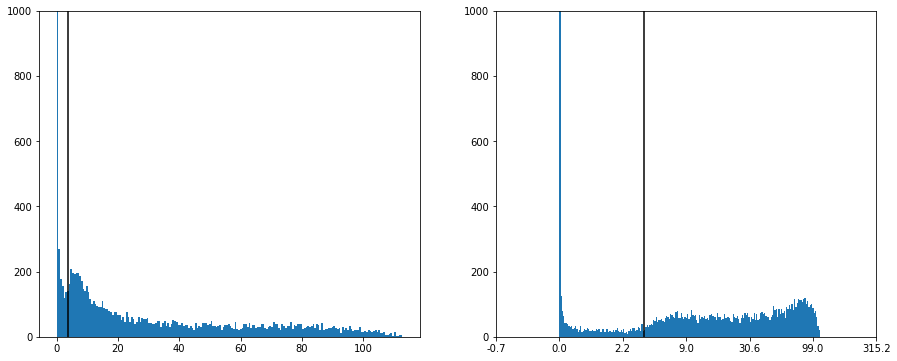

In [41]:
plt.rcParams["figure.figsize"] = (15,6)
plt.subplot(1,2,1)
plt.hist(lofar[lofar["lr_opt"] != 0]["lr_opt"], bins=200)
plt.vlines([threshold_opt], 0, 1000)
plt.ylim([0,1000])

plt.subplot(1,2,2)
plt.hist(np.log10(lofar[lofar["lr_opt"] != 0]["lr_opt"]+1), bins=200)
plt.vlines(np.log10(threshold_opt+1), 0, 1000)
ticks, _ = plt.xticks()
plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
plt.ylim([0,1000]);
plt.show()

In [42]:
lofar["lr_index_sel_opt"] = lofar["lr_index_opt"]
lofar["lr_index_sel_opt"][lofar["lr_opt"] < threshold_opt] = np.nan
print('number of xmatches above the threshold is {}'.format(np.sum(lofar['lr_opt']>threshold_opt)))

number of xmatches above the threshold is 8941


/Users/im281/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/im281/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


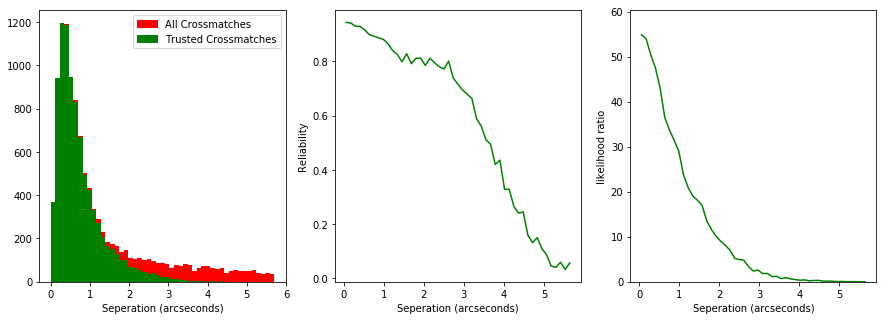

In [43]:
plt.rcParams["figure.figsize"] = (15,5)
bins = np.arange(0,search_rad_opt,search_rad_opt/50)
plt.subplot(1,3,1)
mask = ~np.isnan(lofar['lr_dist_opt'])
plt.hist(lofar['lr_dist_opt'][mask],bins=bins,color='red')
mask = (lofar['lr_opt'] > threshold_opt) & (~np.isnan(lofar['lr_dist_opt']))
plt.hist(lofar['lr_dist_opt'][mask],bins=bins,color='green')
plt.xlabel('Seperation (arcseconds)')
green_patch = mpatches.Patch(color='green',label='Trusted Crossmatches')
red_patch = mpatches.Patch(color='red',label='All Crossmatches')
plt.legend(handles=[red_patch,green_patch])

plt.subplot(1,3,2)
reliability_r = []
mask1 = (~np.isnan(lofar['lr_dist_opt']))
for n in range(len(bins)-1):
    mask = (lofar['lr_dist_opt'] > bins[n]) & (lofar['lr_dist_opt'] < bins[n+1])
    mask = mask
    rel_temp = lofar['lr_reliability_opt'][mask]
    reliability_r.append(np.mean(rel_temp))
rad_cent = get_center(bins)
plt.plot(rad_cent,reliability_r,color='green')
plt.xlabel('Seperation (arcseconds)')
plt.ylabel('Reliability')

plt.subplot(1,3,3)
lrt_r = []
mask1 = (~np.isnan(lofar['lr_dist_opt']))
for n in range(len(bins)-1):
    mask = (lofar['lr_dist_opt'] > bins[n]) & (lofar['lr_dist_opt'] < bins[n+1])
    #mask = mask[mask1]
    rel_temp = lofar['lr_opt'][mask]
    lrt_r.append(np.mean(rel_temp))
rad_cent = get_center(bins)
plt.plot(rad_cent,lrt_r,color='green')
plt.xlabel('Seperation (arcseconds)')
plt.ylabel('likelihood ratio')
plt.ylim(0,np.max(lrt_r)*1.1)

plt.show()

#### IR band

In [44]:
idx_lofar, idx_ir, d2d, d3d = search_around_sky(
    lofar_coords, opt_ir_coords[ir_num], radius*u.arcsec)

idx_lofar_unique = np.unique(idx_lofar)
print('number of LOFAR sources with a possible crossmatch within {} arcseconds is {}'.format(radius,len(idx_lofar_unique)))

number of LOFAR sources with a possible crossmatch within 15 arcseconds is 11564


In [45]:
len(opt_ir_coords[ir_num])

733913

In [46]:
max(idx_ir)

733834

In [47]:
radius = 15
idx_lofar, idx_ir, d2d, d3d = search_around_sky(
    lofar_coords, opt_ir_coords[ir_num], radius*u.arcsec)

# create an array of the indexs of lofar sources with a possible crossmatch within the search radius
idx_lofar_unique = np.unique(idx_lofar)
print('number of LOFAR sources with a possible crossmatch within {} arcseconds is {}'.format(radius,len(idx_lofar_unique)))

number of LOFAR sources with a possible crossmatch within 15 arcseconds is 11564


In [48]:
lofar["lr_ir"] = np.nan                   # Likelihood ratio
lofar["lr_dist_ir"] = np.nan              # Distance to the selected source
lofar["lr_index_ir"] = np.nan             # Index of the PanSTARRS source in combined
lofar["lr_reliability_ir"] = np.nan
lofar["helpid_ir"] = ''

In [49]:
def ml_ir(i):

    idx_0 = idx_ir[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    mag = ir_cat[ir_colname][idx_0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = ir_cat["ra"][idx_0]
    c_dec = ir_cat["dec"][idx_0]
    c_ra_err = 1.0
    c_dec_err = 1.0
    
    sigma, sigma_maj, sigma_min = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)
    
    lr_0 = likelihood_ratio_ir(mag, d2d_0.arcsec, sigma)
    if len(lr_0) == 0:
        result = [np.nan,np.nan,np.nan,np.nan,np.nan]
        return result
    chosen_index = np.argmax(lr_0)
    lr_sum = np.sum(lr_0)
    rel = lr_0/(lr_sum + (1-Q0_opt))
    helpid = ir_cat['help_id'][idx_0][0]
    result = [opt_ir_index[ir_num][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index],
              rel[chosen_index],
              helpid]                                  # LR
    

    return(result)
    #return (result,rel[chosen_index],helpid)

In [50]:
res = parallel_process(idx_lofar_unique, ml_ir, n_jobs=n_cpus)

100%|██████████| 11.6k/11.6k [00:30<00:00, 379it/s]
100%|██████████| 11561/11561 [00:00<00:00, 370865.92it/s]


In [51]:
(lofar["lr_index_ir"][idx_lofar_unique], 
 lofar["lr_dist_ir"][idx_lofar_unique], 
 lofar["lr_ir"][idx_lofar_unique],
 lofar["lr_reliability_ir"][idx_lofar_unique],
 lofar["helpid_ir"][idx_lofar_unique]) = list(map(list, zip(*res)))

/Users/im281/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: StringTruncateWarning: truncated right side string(s) longer than 1 character(s) during assignment


In [52]:
lofar["lr_ir"][np.isnan(lofar["lr_ir"])] = 0

In [53]:
mask = (~np.isnan(lofar['lr_dist_ir'])) & (lofar['lr_ir']>0)
threshold_ir = np.percentile(lofar["lr_ir"][mask], 100*(1 - Q0_ir))
threshold_ir

2.5006399778663124

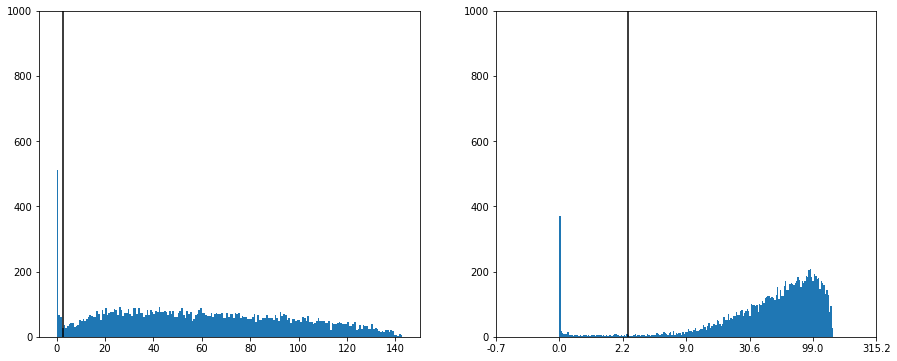

In [54]:
plt.rcParams["figure.figsize"] = (15,6)
plt.subplot(1,2,1)
plt.hist(lofar[lofar["lr_ir"] != 0]["lr_ir"], bins=200)
plt.vlines([threshold_ir], 0, 1000)
plt.ylim([0,1000])

plt.subplot(1,2,2)
plt.hist(np.log10(lofar[lofar["lr_ir"] != 0]["lr_ir"]+1), bins=200)
plt.vlines(np.log10(threshold_ir+1), 0, 1000)
ticks, _ = plt.xticks()
plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
plt.ylim([0,1000]);
plt.show()

In [55]:
lofar["lr_index_sel_ir"] = lofar["lr_index_ir"]
lofar["lr_index_sel_ir"][lofar["lr_ir"] < threshold_ir] = np.nan
print('number of xmatches above the threshold is {}'.format(np.sum(lofar['lr_opt']>threshold_ir)))

number of xmatches above the threshold is 9231


/Users/im281/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/im281/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


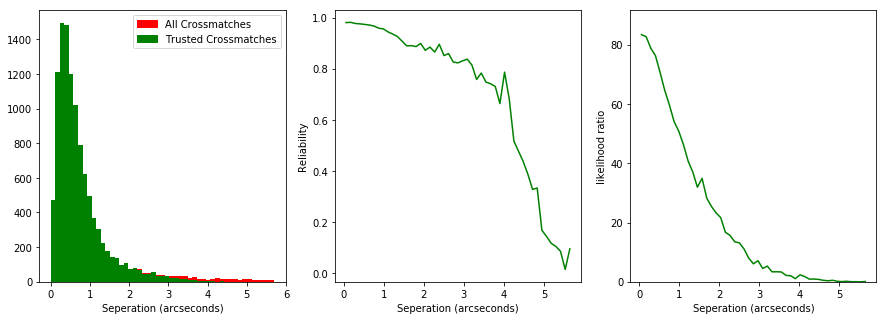

In [56]:
plt.rcParams["figure.figsize"] = (15,5)
bins = np.arange(0,search_rad_opt,search_rad_opt/50)
plt.subplot(1,3,1)
mask = ~np.isnan(lofar['lr_dist_ir'])
plt.hist(lofar['lr_dist_ir'][mask],bins=bins,color='red')
mask = (lofar['lr_ir'] > threshold_ir) & (~np.isnan(lofar['lr_dist_ir']))
plt.hist(lofar['lr_dist_ir'][mask],bins=bins,color='green')
plt.xlabel('Seperation (arcseconds)')
green_patch = mpatches.Patch(color='green',label='Trusted Crossmatches')
red_patch = mpatches.Patch(color='red',label='All Crossmatches')
plt.legend(handles=[red_patch,green_patch])

plt.subplot(1,3,2)
reliability_r = []
mask1 = (~np.isnan(lofar['lr_dist_ir']))
for n in range(len(bins)-1):
    mask = (lofar['lr_dist_ir'] > bins[n]) & (lofar['lr_dist_ir'] < bins[n+1])
    mask = mask
    rel_temp = lofar['lr_reliability_ir'][mask]
    reliability_r.append(np.mean(rel_temp))
rad_cent = get_center(bins)
plt.plot(rad_cent,reliability_r,color='green')
plt.xlabel('Seperation (arcseconds)')
plt.ylabel('Reliability')

plt.subplot(1,3,3)
lrt_r = []
mask1 = (~np.isnan(lofar['lr_dist_ir']))
for n in range(len(bins)-1):
    mask = (lofar['lr_dist_ir'] > bins[n]) & (lofar['lr_dist_ir'] < bins[n+1])
    #mask = mask[mask1]
    rel_temp = lofar['lr_ir'][mask]
    lrt_r.append(np.mean(rel_temp))
rad_cent = get_center(bins)
plt.plot(rad_cent,lrt_r,color='green')
plt.xlabel('Seperation (arcseconds)')
plt.ylabel('likelihood ratio')
plt.ylim(0,np.max(lrt_r)*1.1)

plt.show()

### Final selection of the match

We combine the ML matching done in i-band and W1-band. All the galaxies were the LR is above the selection ratio for the respective band are finally selected.

In [57]:
# lr_opt_and_ir = (lofar["lr_opt"] != 0) & (lofar["lr_ir"] != 0)
# lr_only_opt = (lofar["lr_opt"] != 0) & (lofar["lr_ir"] == 0)
# lr_only_ir = (lofar["lr_opt"] == 0) & (lofar["lr_ir"] != 0)
# lr_no_match = (lofar["lr_opt"] == 0) & (lofar["lr_ir"] == 0)
lr_opt_and_ir = ~np.isnan(lofar["lr_index_sel_opt"]) & ~np.isnan(lofar["lr_index_sel_ir"])
lr_only_opt = ~np.isnan(lofar["lr_index_sel_opt"]) & np.isnan(lofar["lr_index_sel_ir"])
lr_only_ir = np.isnan(lofar["lr_index_sel_opt"]) & ~np.isnan(lofar["lr_index_sel_ir"])
lr_no_match = np.isnan(lofar["lr_index_sel_opt"]) & np.isnan(lofar["lr_index_sel_ir"])

In [58]:
print(np.sum(lr_opt_and_ir))
print(np.sum(lr_only_opt))
print(np.sum(lr_only_ir))
print(np.sum(lr_no_match))

8754
187
2154
540


In [59]:
lofar["lr_index_1"] = np.nan
lofar["lr_dist_1"] = np.nan
lofar["lr_1"] = np.nan
lofar["lr_type_1"] = 0

In [60]:
# Only i matches
lofar["lr_1"][lr_only_opt] = lofar["lr_opt"][lr_only_opt]
lofar["lr_index_1"][lr_only_opt] = lofar["lr_index_opt"][lr_only_opt]
lofar["lr_dist_1"][lr_only_opt] = lofar["lr_dist_opt"][lr_only_opt]
lofar["lr_type_1"][lr_only_opt] = 1

# Only w1 matches
lofar["lr_1"][lr_only_ir] = lofar["lr_ir"][lr_only_ir]
lofar["lr_index_1"][lr_only_ir] = lofar["lr_index_ir"][lr_only_ir]
lofar["lr_dist_1"][lr_only_ir] = lofar["lr_dist_ir"][lr_only_ir]
lofar["lr_type_1"][lr_only_ir] = 2

# Both matches
lofar["lr_1"][lr_opt_and_ir] = np.max([lofar["lr_opt"][lr_opt_and_ir], lofar["lr_ir"][lr_opt_and_ir]], axis=0)
lofar["lr_type_1"][lr_opt_and_ir] = np.argmax([lofar["lr_opt"][lr_opt_and_ir], lofar["lr_ir"][lr_opt_and_ir]], axis=0) + 1

c1 = (lofar["lr_type_1"] == 1)
c2 = (lofar["lr_type_1"] == 2)
lofar["lr_index_1"][lr_opt_and_ir & c1] = lofar["lr_index_opt"][lr_opt_and_ir & c1]
lofar["lr_index_1"][lr_opt_and_ir & c2] = lofar["lr_index_ir"][lr_opt_and_ir & c2]
lofar["lr_dist_1"][lr_opt_and_ir & c1] = lofar["lr_dist_opt"][lr_opt_and_ir & c1]
lofar["lr_dist_1"][lr_opt_and_ir & c2] = lofar["lr_dist_ir"][lr_opt_and_ir & c2]

In [61]:
print("match    sel-opt: ", np.sum(lofar["lr_type_1"][lr_opt_and_ir] == 1))
print("match   sel-ir: ", np.sum(lofar["lr_type_1"][lr_opt_and_ir] == 2))
print("match     both: ", np.sum(lofar["lr_type_1"][lr_opt_and_ir] == 1) + 
                          np.sum(lofar["lr_type_1"][lr_opt_and_ir] == 2))
print("match   opt-only: ", np.sum(lofar["lr_type_1"] == 1) - np.sum(lofar["lr_type_1"][lr_opt_and_ir] == 1))
print("match  ir-only: ", np.sum(lofar["lr_type_1"] == 2) - np.sum(lofar["lr_type_1"][lr_opt_and_ir] == 2))
print("match      all: ", np.sum(lofar["lr_type_1"] == 1) + 
                          np.sum(lofar["lr_type_1"] == 2))
print("         Total: ", len(lofar))

match    sel-opt:  398
match   sel-ir:  8356
match     both:  8754
match   opt-only:  187
match  ir-only:  2154
match      all:  11095
         Total:  11635


In [62]:
print('number of sources for which the match in opt-band and ir-band are above the threshold but gives a different match to the combined catalogue is {}'.format(np.sum(lofar["lr_index_opt"][lr_opt_and_ir] != lofar["lr_index_ir"][lr_opt_and_ir])))

number of sources for which the match in opt-band and ir-band are above the threshold but gives a different match to the combined catalogue is 1038


### Define the colour bins to be used later

Create color bins in the opt-ir plane.

In [63]:
colour_limits = [0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 4.0]

In [64]:
# start with the only opt or ir detected and the colour < lowest colour bin 
colour_bin_def = [{"name":"only W1", "condition": opt_ir_num_ir},
                  {"name":"only i", "condition": opt_ir_num_opt},
                  {"name":"-inf to {}".format(colour_limits[0]), 
                   "condition": (opt_ir["colour"] < colour_limits[0])}]

# Get the colour bins
for i in range(len(colour_limits)-1):
    name = "{} to {}".format(colour_limits[i], colour_limits[i+1])
    condition = ((opt_ir["colour"] >= colour_limits[i]) & 
                 (opt_ir["colour"] < colour_limits[i+1]))
    colour_bin_def.append({"name":name, "condition":condition})

# Add the "more than higher colour" bin
colour_bin_def.append({"name":"{} to inf".format(colour_limits[-1]), 
                       "condition": (opt_ir["colour"] >= colour_limits[-1])})

/Users/im281/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/im281/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)


In [65]:
# assign every source a number based on which colour bin it is in
opt_ir["category"] = np.nan
for i in range(len(colour_bin_def)):
    opt_ir["category"][colour_bin_def[i]["condition"]] = i

In [66]:
numbers_combined_bins = np.array([np.sum(a["condition"]) for a in colour_bin_def])
numbers_combined_bins

array([237371, 662040,  30068,  34848,  56371,  37158,  41589,  42615,
        40476,  36416,  31998,  27124,  22618,  35954,  25546,  33761])

## Skipped bit on duplicated sources

In [67]:
bin_list = [bin_list_ir if i == 0 else bin_list_opt for i in range(len(colour_bin_def))]
centers = [center_ir if i == 0 else center_opt for i in range(len(colour_bin_def))]

numbers_combined_bins = np.array([np.sum(a["condition"]) for a in colour_bin_def])
bandwidth_colour = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
numbers_combined_bins

array([237371, 662040,  30068,  34848,  56371,  37158,  41589,  42615,
        40476,  36416,  31998,  27124,  22618,  35954,  25546,  33761])

In [68]:
#Calculate n(m) and q(m) within each colour bin to give n(m,c) and q(m,c)
n_m_kde = []

# W1 only sources
n_m_kde.append(get_n_m_kde(opt_ir[ir_colname][opt_ir["category"] == 0], 
                       centers[0], field.area, bandwidth=bandwidth_colour[0]))

# Rest of the sources
for i in range(1, len(colour_bin_def)):
    n_m_kde.append(get_n_m_kde(opt_ir[opt_colname][opt_ir["category"] == i], 
                           centers[i], field.area, bandwidth=bandwidth_colour[i]))

In [69]:
n_m = []

# W1 only sources
n_m.append(get_n_m(opt_ir[ir_colname][opt_ir["category"] == 0], bin_list_ir, field.area))

# Rest of the sources
for i in range(1, len(colour_bin_def)):
    n_m.append(get_n_m(opt_ir[opt_colname][opt_ir["category"] == i], bin_list_opt, field.area))

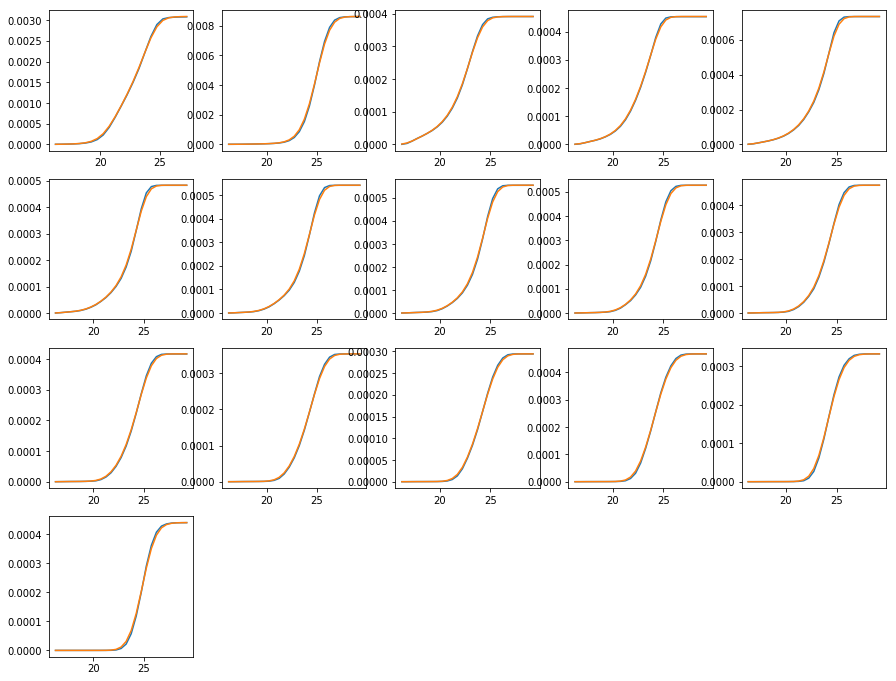

In [70]:
plt.rcParams["figure.figsize"] = (15,15)
for i, n_m_k in enumerate(n_m_kde):
    plt.subplot(5,5,i+1)
    plt.plot(centers[i], n_m[i])
    plt.plot(centers[i], np.cumsum(n_m_k))
plt.show()

In [71]:
lofar["category"] = np.nan
lofar[ir_colname] = np.nan
lofar[opt_colname] = np.nan

In [72]:
c = ~np.isnan(lofar["lr_index_1"])
indices = lofar["lr_index_1"][c].astype(int)
lofar["category"][c] = opt_ir[indices]["category"]
lofar[ir_colname][c] = opt_ir[indices][ir_colname]
lofar[opt_colname][c] = opt_ir[indices][opt_colname]

The next parameter represent the number of matched LOFAR sources in each colour category.

In [73]:
numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                        for c in range(len(numbers_combined_bins))])
numbers_lofar_combined_bins

array([2624,  273,   31,  224,  621,  375,  406,  420,  392,  410,  404,
        464,  494, 1020, 1022, 1915])

In [74]:
#Q0(c) is defined as the fraction of trsuted crossmatches in each category to give a value of Q0 in each category
#and Q0(c) is the sum of these individual Q0's divided by the total number of radio sources
Q_0_colour = numbers_lofar_combined_bins/len(lofar)
q0_total = np.sum(Q_0_colour)
q0_total

0.9535883111302105

In [75]:
#calculate q(m) in each colour bin to calculate q(m,c)
q_m = []
radius = 15. 

# W1 only sources
q_m.append(get_q_m(lofar[ir_colname][lofar["category"] == 0], 
                   bin_list_ir, 
                   numbers_lofar_combined_bins[0], 
                   n_m[0], 
                   field.area, 
                   radius=radius))

# Rest of the sources
for i in range(1, len(numbers_lofar_combined_bins)):
    q_m.append(get_q_m(lofar[opt_colname][lofar["category"] == i], 
                   bin_list_opt, 
                   numbers_lofar_combined_bins[i], 
                   n_m[i], 
                   field.area, 
                   radius=radius))

In [76]:
q_m_kde = []
radius = 15. 

# W1 only sources
q_m_kde.append(get_q_m_kde(lofar[ir_colname][lofar["category"] == 0], 
                   centers[0], 
                   radius=radius,
                   bandwidth=0.5))

# Rest of the sources
for i in range(1, len(numbers_lofar_combined_bins)):
    q_m_kde.append(get_q_m_kde(lofar[opt_colname][lofar["category"] == i], 
                   centers[i], 
                   radius=radius,
                   bandwidth=bandwidth_colour[i]))

In [77]:
np.ones_like(23)
centers[0]

array([16.25, 16.75, 17.25, 17.75, 18.25, 18.75, 19.25, 19.75, 20.25,
       20.75, 21.25, 21.75, 22.25, 22.75, 23.25, 23.75, 24.25, 24.75,
       25.25, 25.75, 26.25, 26.75, 27.25])

In [78]:
np.ones_like(centers[0])*0.5

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

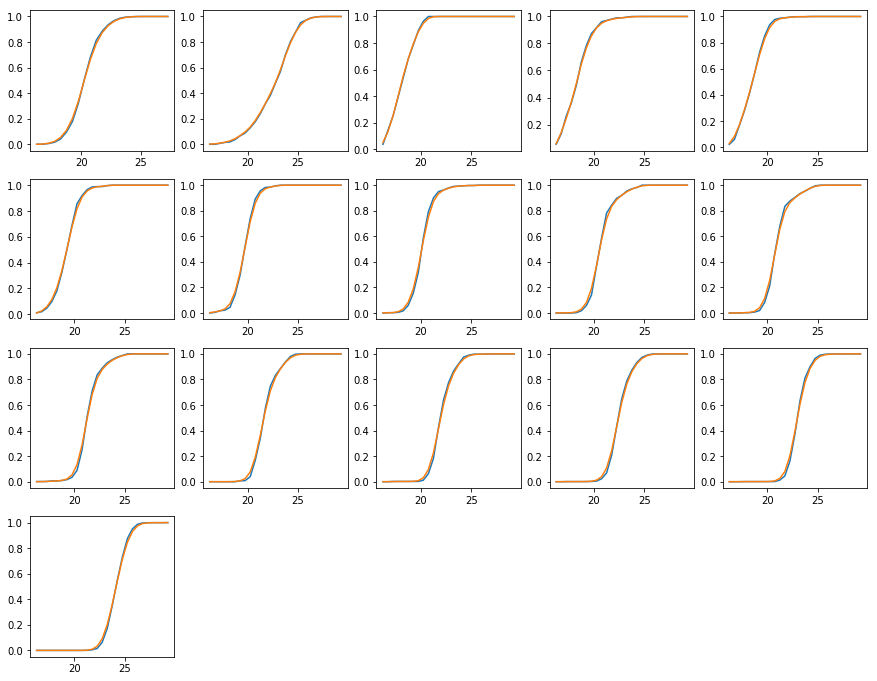

In [79]:
plt.rcParams["figure.figsize"] = (15,15)
for i, q_m_k in enumerate(q_m_kde):
    plt.subplot(5,5,i+1)
    plt.plot(centers[i], q_m[i])
    plt.plot(centers[i], np.cumsum(q_m_k))
plt.show()

/Users/im281/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide


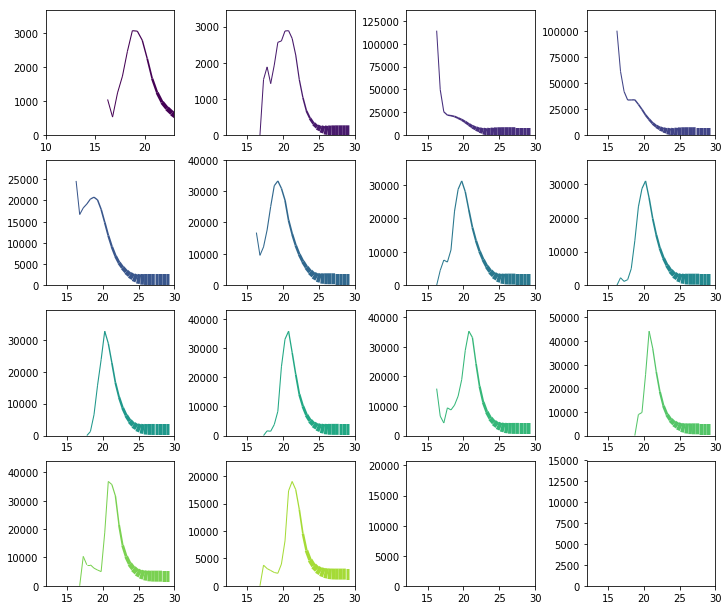

In [80]:
#plot q(m,c)/n(m,c) to see that everthing looks okay. The width of the line shows how many sources are in the bin
plt.rcParams["figure.figsize"] = (12,10)

from matplotlib import cm
from matplotlib.collections import LineCollection

cm_subsection = np.linspace(0., 1., 16) 
colors = [ cm.viridis(x) for x in cm_subsection ]

low = np.nonzero(centers[1] >= 15)[0][0]
high = np.nonzero(centers[1] >= 22.2)[0][0]

fig, a = plt.subplots()

for i, q_m_k in enumerate(q_m):
    #plot(centers[i], q_m_old[i]/n_m_old[i])
    a = plt.subplot(4,4,i+1)
    if i not in [-1]:
        n_m_aux = n_m[i]/np.sum(n_m[i])
        lwidths = (n_m_aux/np.max(n_m_aux)*10).astype(float) + 1
        #print(lwidths)
        
        y_aux = q_m_k/n_m[i]
        mask = ~np.isnan(y_aux)
        y_aux = y_aux[mask]
        factor = np.max(y_aux[low:high])
        y = y_aux
        #print(y)
        x = centers[i]
        
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        lc = LineCollection(segments, linewidths=lwidths, color=colors[i])
        
        a.add_collection(lc)
        
        #plot(centers[i], x/factor, color=colors[i-1])
        plt.xlim([12, 30])
        if i == 0:
            plt.xlim([10, 23])
        plt.ylim([0, 1.2*factor])

plt.subplots_adjust(left=0.125, 
                bottom=0.1, 
                right=0.9, 
                top=0.9,
                wspace=0.4, 
                hspace=0.2)
plt.show()

In [81]:
selection = ~np.isnan(opt_ir["category"]) # Avoid the two dreaded sources with no actual data
catalogue = opt_ir[selection]

In [82]:
radius = 15

In [83]:
def apply_ml(i, likelihood_ratio_function):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    
    category = catalogue["category"][idx_0].astype(int)
    mag = catalogue[opt_colname][idx_0]
    mag[category == 0] = catalogue[ir_colname][idx_0][category == 0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue["ra"][idx_0]
    c_dec = catalogue["dec"][idx_0]
    c_ra_err = 1.0
    c_dec_err = 1.0
    
    sigma, sigma_maj, sigma_min = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)

    lr_0 = likelihood_ratio_function(mag, d2d_0.arcsec, sigma, category)
    if len(lr_0) == 0:

        result = [np.nan,np.nan,np.nan,np.nan,np.nan]
        return result
    chosen_index = np.argmax(lr_0)
    lr_sum = np.sum(lr_0)
    rel = lr_0/(lr_sum + (1-q0_total))
    helpid = catalogue['help_id'][idx_0][0]
    result = [opt_ir_index[selection][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index],
              rel[chosen_index],
              helpid]                                  # LR
    return result

### Run the cross-match

This will not need to be repeated after

In [84]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    lofar_coords, opt_ir_coords[selection], radius*u.arcsec)
idx_lofar_unique = np.unique(idx_lofar)

In [85]:
likelihood_ratio = MultiMLEstimator(Q_0_colour, n_m_kde, q_m_kde, centers)

In [86]:
def ml(i):
    return apply_ml(i, likelihood_ratio)

In [87]:
res = parallel_process(idx_lofar_unique, ml, n_jobs=n_cpus)

100%|██████████| 11.6k/11.6k [00:20<00:00, 565it/s]  
100%|██████████| 11626/11626 [00:00<00:00, 337044.87it/s]


In [88]:
lofar["lr_index_2"] = np.nan
lofar["lr_dist_2"] = np.nan
lofar["lr_2"] = np.nan
lofar["lr_reliability_2"] = np.nan
lofar["helpid_2"] = ''

In [89]:
(lofar["lr_index_2"][idx_lofar_unique], 
 lofar["lr_dist_2"][idx_lofar_unique], 
 lofar["lr_2"][idx_lofar_unique],
 lofar["lr_reliability_2"][idx_lofar_unique],
 lofar["helpid_2"][idx_lofar_unique]) = list(map(list, zip(*res)))

/Users/im281/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: StringTruncateWarning: truncated right side string(s) longer than 1 character(s) during assignment


In [90]:
lofar["lr_2"][np.isnan(lofar["lr_2"])] = 0

mask = (~np.isnan(lofar["lr_dist_2"])) & (lofar['lr_2']>0)
threshold = np.percentile(lofar["lr_2"][mask], 100*(1 - q0_total))
threshold

0.2679172162722483

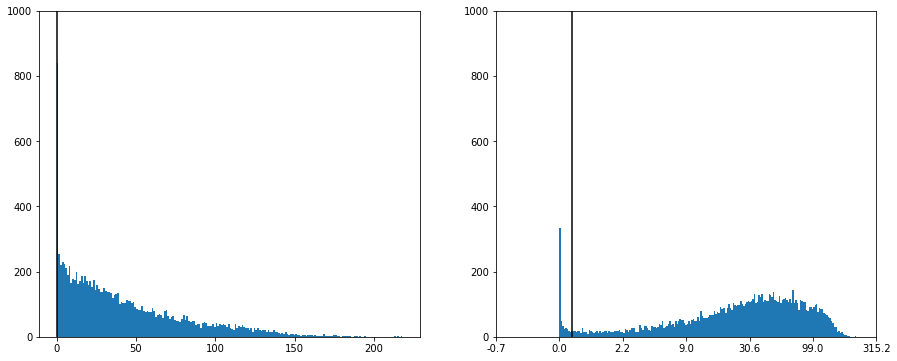

In [91]:
plt.rcParams["figure.figsize"] = (15,6)
plt.subplot(1,2,1)
plt.hist(lofar[lofar["lr_2"] != 0]["lr_2"], bins=200)
plt.vlines([threshold], 0, 1000)
plt.ylim([0,1000])
plt.subplot(1,2,2)
plt.hist(np.log10(lofar[lofar["lr_2"] != 0]["lr_2"]+1), bins=200)
plt.vlines(np.log10(threshold+1), 0, 1000)
ticks, _ = plt.xticks()
plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
plt.ylim([0,1000]);
plt.show()

In [92]:
lofar["lr_index_sel_2"] = lofar["lr_index_2"]
lofar["lr_index_sel_2"][lofar["lr_2"] < threshold] = np.nan

In [93]:
n_changes = np.sum((lofar["lr_index_sel_2"] != lofar["lr_index_1"]) & 
                   ~np.isnan(lofar["lr_index_sel_2"]) &
                   ~np.isnan(lofar["lr_index_1"]))
n_changes

248

In [94]:
lofar["category"] = np.nan
lofar[ir_colname] = np.nan
lofar[opt_colname] = np.nan

c = ~np.isnan(lofar["lr_index_sel_2"])
indices = lofar["lr_index_sel_2"][c].astype(int)
lofar["category"][c] = opt_ir[indices]["category"]
lofar[ir_colname][c] = opt_ir[indices][ir_colname]
lofar[opt_colname][c] = opt_ir[indices][opt_colname]

In [95]:
numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                        for c in range(len(numbers_combined_bins))])
numbers_lofar_combined_bins

array([2700,   89,   26,  221,  618,  375,  417,  423,  391,  415,  408,
        470,  501, 1039, 1044, 1952])

## Skipped rerun iter section

In [96]:
def plot_q_n_m(q_m, n_m):
    fig, a = plt.subplots()

    for i, q_m_k in enumerate(q_m):
        #plot(centers[i], q_m_old[i]/n_m_old[i])
        a = plt.subplot(4,4,i+1)
        if i not in [-1]:
            n_m_aux = n_m[i]/np.sum(n_m[i])
            lwidths = (n_m_aux/np.max(n_m_aux)*10).astype(float) + 1
            #print(lwidths)

            y_aux = q_m_k/n_m[i]
            
            y = y_aux
            mask = ~np.isnan(y_aux)
            y_aux = y_aux[mask]
            factor = np.max(y_aux[low:high])
            #print(y)
            x = centers[i]

            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            lc = LineCollection(segments, linewidths=lwidths, color=colors[i])

            a.add_collection(lc)

            #plot(centers[i], x/factor, color=colors[i-1])
            plt.xlim([12, 30])
            if i == 0:
                plt.xlim([10,23])
            plt.ylim([0, 1.2*factor])

    plt.subplots_adjust(left=0.125, 
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9,
                    wspace=0.4, 
                    hspace=0.2)
    return fig

In [99]:
#create a copy of the radio catalogue for debugging
#original = lofar.copy()

In [100]:
#lofar = original.copy()

In [101]:
#Calculate the LR for radio sources using color
#returns the reliability and other parameters for each potential crossmatch to allow comparison
#the column lr_max is set to true for the crossmatch with the highest LR for each radio source

#the column lr_sel is set to true for the crossmatch with the highest LR for each radio source 
#but will later be set to false if the LR is below the threshold

def apply_ml_all(i, likelihood_ratio_function):
    
    #print(i)
    
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    if len(idx_0) == 0:
        #print('no sources within search radius')
        temp = Table()
        col_index = Column(np.nan,name='lr_index_{}'.format(iteration))
        col_d2d = Column(np.nan,name='lr_dist_{}'.format(iteration))
        col_lr = Column(np.nan,name='lr_{}'.format(iteration))
        col_rel = Column(np.nan,name='lr_reliability_{}'.format(iteration))
        col_sourceid = Column(np.nan,name='Source_id')
        col_helpid = Column('',name='help_id')
        col_lr_max = Column(False,name='lr_max_{}'.format(iteration))
        col_lr_sel = Column(False,name='lr_sel_{}'.format(iteration))
        temp.add_columns([col_index,col_d2d,col_lr,col_rel,col_sourceid,col_helpid,col_lr_max,col_lr_sel])
        return temp,0
    
    category = catalogue["category"][idx_0].astype(int)
    mag = catalogue[opt_colname][idx_0]
    mag[category == 0] = catalogue[ir_colname][idx_0][category == 0]
    #print(mag)
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue["ra"][idx_0]
    c_dec = catalogue["dec"][idx_0]
    c_ra_err = 1.0
    c_dec_err = 1.0
    
    sigma, sigma_maj, sigma_min = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)

    lr_0 = likelihood_ratio_function(mag, d2d_0.arcsec, sigma, category)
    #print(lr_0)

    chosen_index = np.argmax(lr_0)
    lr_sum = np.sum(lr_0)
    rel = lr_0/(lr_sum + (1-q0_total))
    helpid = catalogue['help_id'][idx_0]
    sourceid = (np.zeros(len(lr_0)) + np.unique(lofar['Source_id'])[i]).astype('int')
    col_index = Column(opt_ir_index[selection][idx_0],name='lr_index_{}'.format(iteration))
    col_d2d = Column(d2d_0.arcsec,name='lr_dist_{}'.format(iteration))
    col_lr = Column(lr_0,name='lr_{}'.format(iteration))
    col_rel = Column(rel,name='lr_reliability_{}'.format(iteration))
    col_sourceid = Column(sourceid,name='Source_id')
    col_helpid = Column(helpid,name='help_id')
    col_lr_max = Column(np.zeros(len(lr_0),dtype=bool),name='lr_max_{}'.format(iteration))
    col_lr_max[chosen_index] = True
    col_lr_sel = Column(np.zeros(len(lr_0),dtype=bool),name='lr_sel_{}'.format(iteration))
    col_lr_sel[chosen_index] = True

    #print(col_sourceid)
    #print(col_index,col_d2d,col_lr,col_rel,col_sourceid,col_helpid)
    
    temp = Table([col_index,col_d2d,col_lr,col_rel,col_sourceid,col_helpid,col_lr_max,col_lr_sel])

    lrs = np.max(col_lr)

    return (temp,lrs)

    #return (result)

Iteration 3
numbers_lofar_combined_bins
[2700   89   26  221  618  375  417  423  391  415  408  470  501 1039
 1044 1952]
Q_0_colour
[0.23205844 0.00764933 0.00223464 0.01899441 0.0531156  0.03223034
 0.03584014 0.03635582 0.0336055  0.03566824 0.03506661 0.04039536
 0.04305973 0.08929953 0.08972927 0.16776966]
Q_0_total:  0.953072625698324


100%|██████████| 11.6k/11.6k [00:00<00:00, 12.5kit/s]
100%|██████████| 11626/11626 [00:00<00:00, 311447.21it/s]


Threshold:  0.18714854408610804


/Users/im281/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2051: UserWarning: Warning: converting a masked element to nan.
  res = array(outputs, copy=False, subok=True, dtype=otypes[0])


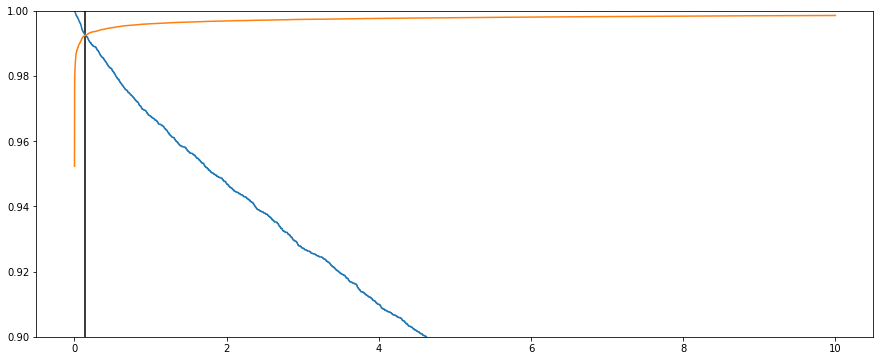

updated Threshold:  0.14400000000000002
N changes:  156111
T changes:  156111
******** continue **********
Iteration 4
numbers_lofar_combined_bins
[2713   63   26  222  619  374  417  423  394  415  408  469  502 1037
 1047 1952]
Q_0_colour
[0.23317576 0.0054147  0.00223464 0.01908036 0.05320155 0.03214439
 0.03584014 0.03635582 0.03386334 0.03566824 0.03506661 0.04030941
 0.04314568 0.08912763 0.08998711 0.16776966]
Q_0_total:  0.9523850451224752


100%|██████████| 11.6k/11.6k [00:45<00:00, 254it/s]  
100%|██████████| 11626/11626 [00:00<00:00, 309993.95it/s]


Threshold:  0.12603399981751853


/Users/im281/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2051: UserWarning: Warning: converting a masked element to nan.
  res = array(outputs, copy=False, subok=True, dtype=otypes[0])


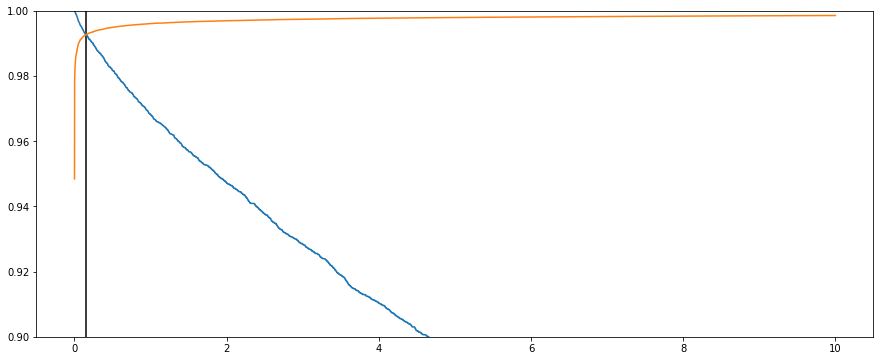

updated Threshold:  0.155
N changes:  160599
T changes:  160599
******** continue **********
Iteration 5
numbers_lofar_combined_bins
[2716   60   24  222  619  375  414  420  397  419  409  472  500 1037
 1047 1941]
Q_0_colour
[0.23343361 0.00515685 0.00206274 0.01908036 0.05320155 0.03223034
 0.03558229 0.03609798 0.03412119 0.03601203 0.03515256 0.04056725
 0.04297379 0.08912763 0.08998711 0.16682424]
Q_0_total:  0.9516115169746454


100%|██████████| 11.6k/11.6k [00:44<00:00, 262it/s]  
100%|██████████| 11626/11626 [00:00<00:00, 165440.12it/s]


Threshold:  0.14412586707226074


/Users/im281/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2051: UserWarning: Warning: converting a masked element to nan.
  res = array(outputs, copy=False, subok=True, dtype=otypes[0])


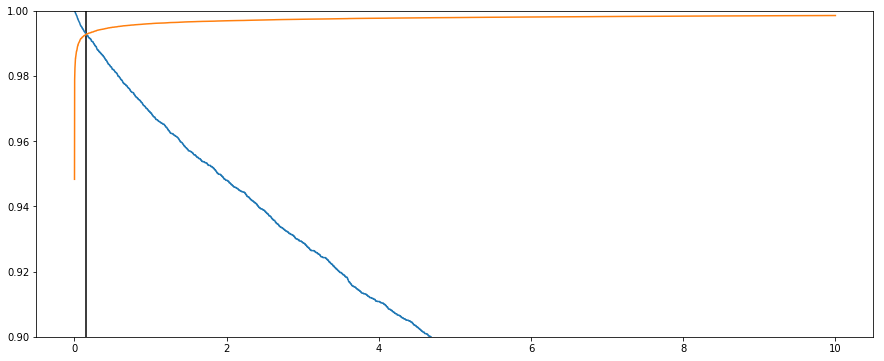

updated Threshold:  0.15
N changes:  0
T changes:  0


In [102]:
for j in range(10):
    iteration = j+3 
    print("Iteration {}".format(iteration))
    print("=============")
    ## Get new parameters
    # Number of matched sources per bin
    
    #select trusted crossmatches to recalculate Q0(c)
    if j==0:
        #for the first iteration need to use sources with LR>threshold as lr_sel hasn't been created for this iteration
        mask_sel = lofar['lr_2']>threshold
    else:
        mask_sel = lofar['lr_sel_{}'.format(iteration-1)]
    numbers_lofar_combined_bins = np.array([np.sum(lofar[mask_sel]["category"] == c) 
                                            for c in range(len(numbers_combined_bins))])
    print("numbers_lofar_combined_bins")
    print(numbers_lofar_combined_bins)
    #recompute Q0(c)
    Q_0_colour_est = numbers_lofar_combined_bins/len(np.unique(lofar['Source_id'])) ### Q_0
    Q_0_colour = q0_min_level(Q_0_colour_est, min_level=0.001)
    print("Q_0_colour")
    print(Q_0_colour)
    q0_total = np.sum(Q_0_colour)
    print("Q_0_total: ", q0_total)
    #Recompute q(m,c) for the new Q0(c)
    q_m = []
    # W1 only sources
    q_m.append(get_q_m(lofar[mask_sel][ir_colname][lofar[mask_sel]["category"] == 0], 
                   bin_list_ir, numbers_lofar_combined_bins[0], 
                   n_m[0], field.area, radius=radius))
    # Rest of the sources
    for i in range(1, len(numbers_lofar_combined_bins)):
        q_m.append(get_q_m(lofar[mask_sel][opt_colname][lofar[mask_sel]["category"] == i], 
                       bin_list_opt, numbers_lofar_combined_bins[i],
                       n_m[i], field.area, radius=radius))
    # q_m
    q_m_kde = []
    # W1 only sources
    q_m_kde.append(get_q_m_kde(lofar[mask_sel][ir_colname][lofar[mask_sel]["category"] == 0], 
                   centers[0], radius=radius, bandwidth=bandwidth_colour[0]))
    # Rest of the sources
    for i in range(1, len(numbers_lofar_combined_bins)):
        q_m_kde.append(get_q_m_kde(lofar[mask_sel][opt_colname][lofar[mask_sel]["category"] == i], 
                       centers[i], radius=radius, bandwidth=bandwidth_colour[i]))
    #set plot_intermediate to True if you want to see plots of n(m,c), q(m,c) and q(m,c)/n(m,c)
    plot_intermediate = False
    if plot_intermediate:
        fig = plt.figure(figsize=(15,15))
        for i, q_m_k in enumerate(q_m_kde):
            plt.subplot(5,5,i+1)
            plt.plot(centers[i], np.cumsum(q_m_k))
        #plt.savefig('{}/q0_{}.png'.format(idp, iteration))
        del fig
        fig = plt.figure(figsize=(15,15))
        for i, q_m_k in enumerate(q_m_kde):
            plt.subplot(5,5,i+1)
            plt.plot(centers[i], q_m_k/n_m[i])
        #plt.savefig('{}/q_over_n_{}.png'.format(idp, iteration))
        del fig
        fig = plot_q_n_m(q_m, n_m)
        #plt.savefig('{}/q_over_n_nice_{}.png'.format(idp, iteration))
        del fig
    ## Define new likelihood_ratio
    likelihood_ratio = MultiMLEstimator(Q_0_colour, n_m_kde, q_m_kde, centers)
    def ml(i):
        return apply_ml_all(i, likelihood_ratio)

    #create an empty table to store the crossmatch results with the same columns in it
    temp = Table()
    col_index = Column(name='lr_index_{}'.format(iteration))
    col_d2d = Column(name='lr_dist_{}'.format(iteration))
    col_lr = Column(name='lr_{}'.format(iteration))
    col_rel = Column(name='lr_reliability_{}'.format(iteration))
    col_sourceid = Column(name='Source_id')
    col_helpid = Column(name='help_id')
    temp.add_columns([col_index,col_d2d,col_lr,col_rel,col_sourceid,col_helpid])
    #run the LR calculation
    res = parallel_process(np.unique(idx_lofar), ml, n_jobs=n_cpus)
    test1 = np.transpose(res)
    test2 = test1[0].tolist()
    res = astropy.table.vstack(test2)
    #create a array of highest LR for each radio source
    lrs = test1[1]
    
    
    res["lr_{}".format(iteration)][np.isnan(res["lr_{}".format(iteration)])] = 0
    ## Get and apply the threshold calculated from Q0(c) 
    mask = res['lr_sel_{}'.format(iteration)]
    threshold = np.percentile(res[mask]['lr_{}'.format(iteration)], 100*(1 - q0_total))
    print("Threshold: ", threshold)
    
    #change lr_sel to False if the value is less than the threshold
    #for n,row in enumerate(res[res['lr_max_{}'.format(iteration)]]):
    #    if row['lr_{}'.format(iteration)]<threshold:
    #        mask = res['help_id']==row['help_id']
    #        res['lr_sel_{}'.format(iteration)][mask] = False             
    
    #Calculate the completeness and reliability as a function of the threshold
    #Use this to calculate the thershold that gives an equal completeness and reliability
    def completeness(lr, threshold, q0):
        n = len(lr)
        lrt = lr[lr < threshold]
        return 1. - np.sum((q0 * lrt)/(q0 * lrt + (1 - q0)))/(float(n)*q0)
    
    def reliability(lr, threshold, q0):
        n = len(lr)
        lrt = lr[lr > threshold]
        return 1. - np.sum((1. - q0)/(q0 * lrt + (1 - q0)))/(float(n)*q0)
    completeness_v = np.vectorize(completeness, excluded=[0])
    reliability_v = np.vectorize(reliability, excluded=[0])
    thresholds = np.arange(0., 10., 0.001)
    mask = lofar['lr_max_{}'.format(iteration)]
    lr_temp = lofar['lr_{}'.format(iteration)][mask]
    completeness_t = completeness_v(lr_temp , thresholds, Q0)
    reliability_t = reliability_v(lr_temp , thresholds, Q0)
    diff = abs(completeness_t-reliability_t)
    mask = ~np.isnan(diff)
    index = np.argmin(diff[mask])
    threshold = thresholds[mask][index]
    plt.plot(thresholds,completeness_t)
    plt.plot(thresholds,reliability_t)
    plt.vlines(threshold,0,1)
    plt.ylim(0.9,1.0)
    plt.show()
    print("updated Threshold: ", threshold)

    for n,row in enumerate(res[res['lr_max_{}'.format(iteration)]]):#####
        if row['lr_{}'.format(iteration)]<threshold:
            mask = res['help_id']==row['help_id']
            res['lr_sel_{}'.format(iteration)][mask] = False
        #only include if you uncomment the earlier redoing of lr_sel after calculating the first threshold
        #based on Q0(c)
        #else:
        #    mask = res['help_id']==row['help_id']
        #    res['lr_sel_{}'.format(iteration)][mask] = True
    
    #join the crossmatch data to te radio table the first time this is done an outer join
    #is needed as there are multiple crossmatches for each radio source and all of these are needed
    #For subsequent iterations a hstack can be used 
    if j==0:
        lofar = join(lofar,res,keys='Source_id',join_type='outer')
    else:
        res.remove_column('Source_id')
        lofar = astropy.table.hstack([lofar,res])
    
    if plot_intermediate:
        fig = plt.figure(figsize=(15,6))
        plt.subplot(1,2,1)
        plt.hist(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)], bins=200)
        plt.vlines([threshold], 0, 1000)
        plt.ylim([0,1000])
        plt.subplot(1,2,2)
        plt.hist(np.log10(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)]+1), bins=200)
        plt.vlines(np.log10(threshold+1), 0, 1000)
        ticks, _ = plt.xticks()
        plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
        plt.ylim([0,1000])
        #plt.savefig('{}/lr_distribution_{}.png'.format(idp, iteration))
        del fig
    ## Apply the threshold

    ## Enter changes into the catalogue
    # Clear aux columns
    lofar["category"] = np.nan
    lofar[ir_colname] = np.nan
    lofar[opt_colname] = np.nan
    # Update data
    c = ~np.isnan(lofar["lr_index_{}".format(iteration)])
    indices = lofar["lr_index_{}".format(iteration)][c].astype(int)
    lofar["category"][c] = opt_ir[indices]["category"]
    lofar[ir_colname][c] = opt_ir[indices][ir_colname]
    lofar[opt_colname][c] = opt_ir[indices][opt_colname]
    '''# Save the data
    if save_intermediate:
        lofar[mask_sel].write("{}/lofar[mask_sel]_m{}.fits".format(idp, iteration), format="fits")'''
    ## Compute number of changes
    n_changes = np.sum((
            lofar["lr_index_{}".format(iteration)] != lofar["lr_index_{}".format(iteration-1)]) & 
            ~np.isnan(lofar["lr_index_{}".format(iteration)]) &
            ~np.isnan(lofar["lr_index_{}".format(iteration-1)]))
    print("N changes: ", n_changes)
    t_changes = np.sum((
            lofar["lr_index_{}".format(iteration)] != lofar["lr_index_{}".format(iteration-1)]))
    print("T changes: ", t_changes)
    ## Check changes
    plt.show()
    if n_changes == 0:
        break
    else:
        print("******** continue **********")

In [115]:
Table.write(lofar,'data/xmatch_all_20181113',format='fits')

In [ ]:
lofar